# UFC Fight Analysis

**By: [Courtney Ferguson Lee](linkedin.com/in/courtneyfergusonlee)**

<img src = 'https://rawgit.com/spacecadet84/ufc_fight_analysis/master/images/ufc_fighter_red_wordcloud.png'>

 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Todo" data-toc-modified-id="Todo-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Todo</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Ideas" data-toc-modified-id="Ideas-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Ideas</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Introduction" data-toc-modified-id="Introduction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Background" data-toc-modified-id="Background-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Data" data-toc-modified-id="Data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Observations" data-toc-modified-id="Observations-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Observations</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Missing-Data" data-toc-modified-id="Missing-Data-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Missing Data</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Minor-Aesthetics" data-toc-modified-id="Minor-Aesthetics-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Minor Aesthetics</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Rearranging-Columns" data-toc-modified-id="Rearranging-Columns-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Rearranging Columns</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Reversing-the-Fight-Order" data-toc-modified-id="Reversing-the-Fight-Order-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Reversing the Fight Order</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Editing-Name-Column" data-toc-modified-id="Editing-Name-Column-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Editing Name Column</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Comparing-Winners-and-Losers" data-toc-modified-id="Comparing-Winners-and-Losers-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Comparing Winners and Losers</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Variables" data-toc-modified-id="Variables-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Variables</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Heatmap" data-toc-modified-id="Heatmap-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Heatmap</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Strike-Targets" data-toc-modified-id="Strike-Targets-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Strike Targets</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Body" data-toc-modified-id="Body-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>Body</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Head" data-toc-modified-id="Head-8.2.2"><span class="toc-item-num">8.2.2&nbsp;&nbsp;</span>Head</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Leg" data-toc-modified-id="Leg-8.2.3"><span class="toc-item-num">8.2.3&nbsp;&nbsp;</span>Leg</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Strike-Types" data-toc-modified-id="Strike-Types-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Strike Types</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Ground-and-Pound" data-toc-modified-id="Ground-and-Pound-8.3.1"><span class="toc-item-num">8.3.1&nbsp;&nbsp;</span>Ground and Pound</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Distance" data-toc-modified-id="Distance-8.3.2"><span class="toc-item-num">8.3.2&nbsp;&nbsp;</span>Distance</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Clinch" data-toc-modified-id="Clinch-8.3.3"><span class="toc-item-num">8.3.3&nbsp;&nbsp;</span>Clinch</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Significant-Strikes" data-toc-modified-id="Significant-Strikes-8.3.4"><span class="toc-item-num">8.3.4&nbsp;&nbsp;</span>Significant Strikes</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Overall-Strikes" data-toc-modified-id="Overall-Strikes-8.3.5"><span class="toc-item-num">8.3.5&nbsp;&nbsp;</span>Overall Strikes</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Grappling" data-toc-modified-id="Grappling-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>Grappling</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Submissions" data-toc-modified-id="Submissions-8.4.1"><span class="toc-item-num">8.4.1&nbsp;&nbsp;</span>Submissions</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Passes" data-toc-modified-id="Passes-8.4.2"><span class="toc-item-num">8.4.2&nbsp;&nbsp;</span>Passes</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Reversals" data-toc-modified-id="Reversals-8.4.3"><span class="toc-item-num">8.4.3&nbsp;&nbsp;</span>Reversals</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Takedowns" data-toc-modified-id="Takedowns-8.4.4"><span class="toc-item-num">8.4.4&nbsp;&nbsp;</span>Takedowns</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Knockdowns" data-toc-modified-id="Knockdowns-8.5"><span class="toc-item-num">8.5&nbsp;&nbsp;</span>Knockdowns</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Referees-and-Fighters" data-toc-modified-id="Referees-and-Fighters-8.6"><span class="toc-item-num">8.6&nbsp;&nbsp;</span>Referees and Fighters</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Rounds" data-toc-modified-id="Rounds-8.7"><span class="toc-item-num">8.7&nbsp;&nbsp;</span>Rounds</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Method" data-toc-modified-id="Method-8.8"><span class="toc-item-num">8.8&nbsp;&nbsp;</span>Method</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Data-Cleaning" data-toc-modified-id="Data-Cleaning-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Data Cleaning</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Dropping-No-Contests,-DQ's,-etc" data-toc-modified-id="Dropping-No-Contests,-DQ's,-etc-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Dropping No Contests, DQ's, etc</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Checking-for-NaN's" data-toc-modified-id="Checking-for-NaN's-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Checking for NaN's</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Extracting-Country-from-B_Location-and-R_Location" data-toc-modified-id="Extracting-Country-from-B_Location-and-R_Location-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>Extracting Country from B_Location and R_Location</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Converting-Strings-to-Categories" data-toc-modified-id="Converting-Strings-to-Categories-9.4"><span class="toc-item-num">9.4&nbsp;&nbsp;</span>Converting Strings to Categories</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Feature-Engineering" data-toc-modified-id="Feature-Engineering-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Modeling" data-toc-modified-id="Modeling-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Trying-to-improve-results-by-dividing-features" data-toc-modified-id="Trying-to-improve-results-by-dividing-features-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Trying to improve results by dividing features</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Dropping-First-Fights" data-toc-modified-id="Dropping-First-Fights-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Dropping First Fights</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Aggregate-Round-Stats" data-toc-modified-id="Aggregate-Round-Stats-11.3"><span class="toc-item-num">11.3&nbsp;&nbsp;</span>Aggregate Round Stats</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Comparing-Red-to-Blue" data-toc-modified-id="Comparing-Red-to-Blue-11.4"><span class="toc-item-num">11.4&nbsp;&nbsp;</span>Comparing Red to Blue</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Reducing-Features" data-toc-modified-id="Reducing-Features-11.5"><span class="toc-item-num">11.5&nbsp;&nbsp;</span>Reducing Features</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Conclusion" data-toc-modified-id="Conclusion-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Stretch-Goals" data-toc-modified-id="Stretch-Goals-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Stretch Goals</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Rewrite-and-re-run-scraper-to-pull-data-from-earlier-years" data-toc-modified-id="Rewrite-and-re-run-scraper-to-pull-data-from-earlier-years-13.1"><span class="toc-item-num">13.1&nbsp;&nbsp;</span>Rewrite and re-run scraper to pull data from earlier years</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Scraper-Rewrite" data-toc-modified-id="Scraper-Rewrite-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Scraper Rewrite</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Fight-URL-Scraper" data-toc-modified-id="Fight-URL-Scraper-14.1"><span class="toc-item-num">14.1&nbsp;&nbsp;</span>Fight URL Scraper</a></span></li><li><span><a href="http://localhost:8888/notebooks/ufc_fight_analysis/ufc_analysis.ipynb#Fight-Scraper" data-toc-modified-id="Fight-Scraper-14.2"><span class="toc-item-num">14.2&nbsp;&nbsp;</span>Fight Scraper</a></span></li></ul></li></ul></div>


## Todo

1. Graph several variables:
  1. Counts with sns.barplot
  2. Counts with plt.plot
  3. Violin plot of one variable over several categories
  4. sns.distplot of numerical variable
  5. Def look at round data
  6. Heatmap
  7. Wordcloud of referee names
  8. Jointplot of two variables
1. Create percentages column for each landed / attempted statistic
2. Aggregate all data so it's ongoing
  1. Sum each fighter's data to make it possible to compare fighters in a reasonable way
  2. One idea is to subtract two fighters' non-ratio stats and use them as labels
  3. You can still use ratio stats as labels
3. Rewrite models to account for the unbalanced data.
  1. Most fights are won by decision, so that should be accounted for
4. Add visuals

## Ideas

Go through all through all the steps and clean it up at the end. You don't have to worry about doing exploratory analysis twice. You're going to have to do that anyway because you have to:

1. Get a feel for the dataset
2. Show what's happening with the dataset after making changes

Go through it and refine it later.

I'm just spitballing but I think the fighter with the most strikes landed will usually win. We can test this by turning each fight into differences. We will subtract one fighter's stats from the other, including strikes, submissions attempted, KO wins, KO losses, sub wins, etc. Then, we'll feed the data into the algorithm and assess the results. Currently, the algorithm is just looking at each fight's stats and judging the winner. That's not very realistic or useful tbh...

This will be a cool project, even if the results don't turn out the way I expected. We'll work on this in a couple stages:

1. Clean up data. Check for:
  1. Misspellings
  2. Logical errors (strikes landed > strikes attempted, etc)
  3. Incorrect data types
  4. Missing data
  5. Convert strings to categories? Not many categorical vars, so we'll leave this as a stretch goal.
2. Create df of running tallies. We'll have to put more thought into it, but searching for previous columns with that name and adding them together.
  1. Create two dataframes: winners and losers
  1. Use the shift function
  2. Divide one fighter's relevant stats by the other's
  3. Keep the non-relevant stats for the respective winner/loser
  5. Join the two dataframes and compare the stats
3. Only include non-debut fights? There will be no data for that fighter, which may skew results but I'm also curious about the outcome. I might include it anyway to see if there are any patterns.
4. In each fight, subtract one fighter's stats from the other
5. Another idea for comparing fighters: fighter strike to opponent strike ratio

There are so many areas to explore. Keep putting one foot in front of the other. This is shaping up to be a very interesting project!

## Introduction

## Background

## Data

This data was scraped from www.fightmetrics.com with Beautiful Soup in two stages. The first script compiled a list of event urls and wrote them to a CSV. The second script crawled through those urls and extracted all available fight data into a pandas dataframe. There are 29 columns and 8774 records.

During exploratory data analysis, we'll take a look at the data from several perspectives. The first will be a bird's eye view of the data. We'll look at a heatmap of all the variables to see if we can tease out any patterns. Next we'll inspect each feature, restricting our view to univariate distributions and a select number of bivariate distributions. After we get a good sense of each individual variable, we will look for multivariate relationships.

In [1]:
# Imports and Helper Functions
# data Analysis
import pandas as pd
import seaborn as sns
import numpy as np
import random as rng
from pprint import pprint
from scipy.stats import norm
color = sns.color_palette()
import random

# Web Scraping
import json
import codecs
import csv
import datetime
from bs4 import BeautifulSoup
import requests
import cStringIO
import pprint

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from PIL import Image
from wordcloud import WordCloud

#SciKit Learn Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

from subprocess import check_output
print check_output(["ls", "data"]).decode("utf8")
fight_data = pd.read_csv("data/fights.csv")
fight_df = pd.DataFrame(fight_data)
# Any results you write to the current directory are saved as output.

# Noteboook Functionality
#from IPython.core.interactiveshell import InteractiveShell # All statements are printed to output
#InteractiveShell.ast_node_interactivity = "all"

data.csv
data.csv.zip
fight urls.csv
fights.csv



In [2]:
fight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8774 entries, 0 to 8773
Data columns (total 29 columns):
body                 8774 non-null int64
body_attempts        8774 non-null int64
clinch               8774 non-null int64
clinch_attempts      8774 non-null int64
distance             8774 non-null int64
distance_attempts    8774 non-null int64
fight_id             8774 non-null int64
ground               8774 non-null int64
ground_attempts      8774 non-null int64
head                 8774 non-null int64
head_attempts        8774 non-null int64
kd                   8774 non-null int64
leg                  8774 non-null int64
leg_attempts         8774 non-null int64
method               8774 non-null object
name_first           8774 non-null object
name_last            8774 non-null object
pass                 8774 non-null int64
referee              8738 non-null object
reversals            8774 non-null int64
round                8774 non-null int64
sig_attempts         8774 no

From this, we can see that we have a total of 29 Columns and one dependent variable. The columns themselves have 4 object types (First Name, Last Name, Method and Referee), and 25 Float types. This however does not give us a complete picture of the data, so we'll using a few other pandas functions to get a better glimpse. 

In [3]:
fight_df.describe()

,body,body_attempts,clinch,clinch_attempts,distance,distance_attempts,fight_id,ground,ground_attempts,head,...,reversals,round,sig_attempts,sig_strikes,strike_attempts,strikes,sub_attempts,takedowns,td_attempts,win/loss
count,8774.000000,8774.000000,8774.000000,8774.000000,8774.000000,8774.000000,8774.000000,8774.000000,8774.000000,8774.000000,...,8774.000000,8774.000000,8774.000000,8774.000000,8774.000000,8774.000000,8774.000000,8774.000000,8774.000000,8774.000000
mean,5.961591,8.703556,5.236152,7.848986,19.463415,54.518578,2193.618874,5.206633,7.829154,19.022795,...,0.140187,2.264418,70.196718,29.906200,91.531571,48.951333,0.456234,1.098017,2.844883,0.500000
std,7.138084,10.033876,7.590997,10.711031,22.495543,58.464204,1267.532948,9.037458,13.385800,18.748625,...,0.427533,1.008035,62.533774,26.796296,72.518595,41.855437,0.911112,1.695560,3.691603,0.500028
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,1.000000,3.000000,11.000000,1096.250000,0.000000,0.000000,5.000000,...,0.000000,1.000000,22.000000,9.000000,31.000000,16.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,5.000000,2.000000,4.000000,12.000000,34.000000,2193.000000,1.000000,2.000000,14.000000,...,0.000000,3.000000,54.000000,23.000000,78.000000,40.000000,0.000000,0.000000,1.000000,0.500000
75%,9.000000,13.000000,7.000000,11.000000,27.000000,79.000000,3289.750000,7.000000,10.000000,27.000000,...,0.000000,3.000000,101.000000,44.000000,136.000000,71.000000,1.000000,2.000000,4.000000,1.000000
max,92.000000,101.000000,95.000000,115.000000,228.000000,447.000000,4412.000000,100.000000,136.000000,199.000000,...,5.000000,5.000000,495.000000,238.000000,497.000000,361.000000,10.000000,21.000000,33.000000,1.000000


In [4]:
fight_df.describe(include=['O'])

,method,name_first,name_last,referee
count,8774,8774,8774,8738
unique,8,900,1483,155
top,Decision,Chris,Silva,Herb Dean
freq,3784,147,102,1306


### Observations

Most of the variables have low means and large maximum values, which means they are probably highly skewed to the right. It might make sense to apply a log transform to some of the distributions when conducting the univariate analysis.

In the categorical overview, we can see that Herb Dean is truly a prolific ref! Who knew that he officiated over 1300 UFC fights? I would've guessed John McCarthy was the leader in that respect, but Herb Dean has definitely paid his dues. Right now the fighter names are split into first and last columns so there doesn't seem to be a pattern, but later in the analysis I pull them back together to make them more readable. You'll never guess who's the most prolific UFC fighter. Spoler alert: It's Jim Miller. I bet he wasn't even on your radar.

### Missing Data

Nothing to see here. The only column that has any missing data is the referee column and it's only 4%. Let's keep it moving

In [5]:
percent_missing = (fight_df.isnull().sum()/fight_df.isnull().count()).sort_values()
percent_missing

body                 0.000000
takedowns            0.000000
sub_attempts         0.000000
strikes              0.000000
strike_attempts      0.000000
sig_strikes          0.000000
sig_attempts         0.000000
round                0.000000
reversals            0.000000
pass                 0.000000
name_last            0.000000
name_first           0.000000
td_attempts          0.000000
method               0.000000
leg                  0.000000
kd                   0.000000
head_attempts        0.000000
head                 0.000000
ground_attempts      0.000000
ground               0.000000
fight_id             0.000000
distance_attempts    0.000000
distance             0.000000
clinch_attempts      0.000000
clinch               0.000000
body_attempts        0.000000
leg_attempts         0.000000
win/loss             0.000000
referee              0.004103
dtype: float64

In [6]:
fight_df.skew()

body                 2.333429
body_attempts        2.225058
clinch               2.960951
clinch_attempts      2.769409
distance             2.168737
distance_attempts    1.767322
fight_id             0.002696
ground               3.258335
ground_attempts      3.093664
head                 1.869759
head_attempts        1.597050
kd                   2.620011
leg                  2.667526
leg_attempts         2.677855
pass                 2.932443
reversals            3.664056
round                0.183691
sig_attempts         1.444965
sig_strikes          1.570874
strike_attempts      1.009758
strikes              1.395795
sub_attempts         2.842687
takedowns            2.397869
td_attempts          1.910064
win/loss             0.000000
dtype: float64

## Minor Aesthetics

Before diving deeper into the dataset, let's take a moment to fix a few minor details.

### Rearranging Columns

It bugs me slightly that each fighter's name is buried in the middle of the dataframe. The analysis will be a lot simpler if that information was the first thing we saw in each row. Let's take care of that and move the win/loss column to the front as well.

In [7]:
# Creates a copy of the dataframe for testing
fight_df = pd.DataFrame(fight_data.copy())

# Rearranges the columns so the first name, last name and win/loss appear first
cols = fight_df.columns.tolist()
cols = cols[15:17] + cols[28:29] + cols[14:15] + cols[:14] + cols[17:28]

fight_df = fight_df[cols]

# Sets the index as the fight_id
# fight_df.set_index('fight_id', inplace=True)

# Change kd to knock_down for readability
fight_df.rename(columns={'kd': 'knockdowns'}, inplace=True)

fight_df.to_csv('fights.csv', index=False)
fight_df.head()

,name_first,name_last,win/loss,method,body,body_attempts,clinch,clinch_attempts,distance,distance_attempts,...,referee,reversals,round,sig_attempts,sig_strikes,strike_attempts,strikes,sub_attempts,takedowns,td_attempts
0,Ovince,Saint,1,Submission,0,0,0,0,0,0,...,Leon Roberts,0,1,0,0,3,3,1,0,0
1,Preux,Yushin,0,Submission,0,0,0,0,0,0,...,Leon Roberts,0,1,0,0,0,0,1,0,1
2,Claudia,Gadelha,1,Decision,1,4,9,15,30,71,...,John Sharp,0,3,91,42,96,47,2,0,7
3,Jessica,Andrade,0,Decision,50,58,18,25,45,107,...,John Sharp,0,3,241,141,355,242,0,4,7
4,Takanori,Gomi,1,KO/TKO,1,1,0,0,2,3,...,Steve Perceval,0,1,3,2,3,2,0,0,0


### Reversing the Fight Order

Right off the bat I can see the data is organized in reverse-chronological order. Art Jimmerson fought in the first UFC event and I still remember him because he fought with one boxing glove. It was a crazy time... I'll reverse the dataframe so it's in chronological order and re-index the records. 

I'm surprised by the lack of NaN values in this dataset. Apparently, Fightmetrics is very organized! I'll have to crawl deep to see if there are any inconsistencies.

In [8]:
fight_df['fight_id'] = abs(4412 - fight_df['fight_id'])
fight_df = fight_df[::-1]
index = list(range(8774))
fight_df.index = index

In [9]:
fight_df.head()

,name_first,name_last,win/loss,method,body,body_attempts,clinch,clinch_attempts,distance,distance_attempts,...,referee,reversals,round,sig_attempts,sig_strikes,strike_attempts,strikes,sub_attempts,takedowns,td_attempts
0,Teila,Tuli,0,KO/TKO,0,0,0,0,0,1,...,Joao Barreto,0,1,1,0,1,0,0,0,1
1,Gerard,Gordeau,1,KO/TKO,0,0,0,0,1,3,...,Joao Barreto,0,1,5,3,5,3,0,0,0
2,Zane,Frazier,0,KO/TKO,3,6,10,19,0,7,...,Joao Barreto,0,1,28,12,29,13,0,0,0
3,Kevin,Rosier,1,KO/TKO,3,4,4,9,4,10,...,Joao Barreto,0,1,27,15,53,38,0,0,0
4,Art,Jimmerson,0,Submission,0,0,0,0,0,0,...,Joao Barreto,0,1,0,0,0,0,0,0,0


In [10]:
fight_df.tail()

,name_first,name_last,win/loss,method,body,body_attempts,clinch,clinch_attempts,distance,distance_attempts,...,referee,reversals,round,sig_attempts,sig_strikes,strike_attempts,strikes,sub_attempts,takedowns,td_attempts
8769,Takanori,Gomi,1,KO/TKO,1,1,0,0,2,3,...,Steve Perceval,0,1,3,2,3,2,0,0,0
8770,Jessica,Andrade,0,Decision,50,58,18,25,45,107,...,John Sharp,0,3,241,141,355,242,0,4,7
8771,Claudia,Gadelha,1,Decision,1,4,9,15,30,71,...,John Sharp,0,3,91,42,96,47,2,0,7
8772,Preux,Yushin,0,Submission,0,0,0,0,0,0,...,Leon Roberts,0,1,0,0,0,0,1,0,1
8773,Ovince,Saint,1,Submission,0,0,0,0,0,0,...,Leon Roberts,0,1,0,0,3,3,1,0,0


Ah, much better! The earliest fights are at the beginning of the dataset and the later fights are at the end. Now to dive into the variables.

### Editing Name Column

The fighter names are split into first and last, which doesn't seem necessary. I'll combine them into one column, but first I want to check to make sure there are no missing values.

In [11]:
print(fight_df[fight_df['name_first'].str.isalpha()==False].iloc[:,:5])
fight_df[fight_df['name_last'].str.isalpha()==False].iloc[-7:,:5]

       name_first name_last  win/loss      method  body
4439     Nah-Shon   Burrell         1    Decision    16
4638     Nah-Shon   Burrell         0    Decision    29
8000          Jr.     Tyson         0  Submission     1
8602          Jr.      Paul         0      KO/TKO     3
8690  Abdul-Kerim    Edilov         0      KO/TKO    16


,name_first,name_last,win/loss,method,body
7751,Ashlee,Evans-Smith,1,KO/TKO,27
8052,Sean,O'Connell,0,KO/TKO,2
8069,Olivier,Aubin-Mercier,1,Submission,2
8137,Jocelyn,Jones-Lybarger,1,Submission,2
8347,Ashlee,Evans-Smith,1,Decision,17
8720,Ashlee,Evans-Smith,0,Submission,2
8740,Olivier,Aubin-Mercier,0,Decision,3


There are non-alpha characters in the first and last names columns but they are within the normal range. Periods (Jr.), hyphens (St-Pierre) and apostrophes (O'Brien) are to be expected. Now, to combine the first and last names for each figher.

In [12]:
fight_df.loc[:,'name'] = fight_df['name_first'] + ' ' + fight_df['name_last']
fight_df['name'].head()
del fight_df['name_first']
del fight_df['name_last']
cols = fight_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
fight_df = fight_df[cols]

## Comparing Winners and Losers

Next, I will create a running tally of differences between each fighter in each fight. My hope is that by comparing the winners and losers of each individual fight, I might be able to determine which features, if any can predict success in the UFC.

I will look at both ratios and differences, but I want to start with differences first. Right off the bat, I can see that the ratio strategy will come with its own set of challenges because of the number of values that are equal to zero. It may be possible to add one to all relevant columns to overcome this, but I want to tackle the easier problem first.

Here's what the process will look like:

1. Create two dataframes: winners and losers
2. Use the shift function
3. Subtract one fighter's relevant stats by the other's
4. Keep the non-relevant stats for the respective winner/loser
5. Join the two dataframes and compare the stats
6. Repeat the process using division

Let's get to work!

In [13]:
fight_copy = fight_df.copy()
len(fight_copy.loc[(fight_copy['win/loss']==1) & (fight_copy.index%2==0)])

0

The winners are always presented first, which will make the process of separating winners and losers slightly easier.

In [14]:
cols = [u'body', u'body_attempts', u'clinch', u'clinch_attempts', u'distance',
       u'distance_attempts', u'ground', u'ground_attempts',
       u'head', u'head_attempts', u'knockdowns', u'leg', u'leg_attempts',
       u'pass', u'reversals', u'sig_attempts', u'sig_strikes',
       u'strike_attempts', u'strikes', u'sub_attempts', u'takedowns',
       u'td_attempts']

fighter_a = fight_df[fight_df.index%2==0]
fighter_b = fight_df[fight_df.index%2==1]

fighter_a.reset_index(inplace=True, drop=True)
fighter_b.reset_index(inplace=True, drop=True)

fight_loser = fighter_a.copy()
fight_winner = fighter_b.copy()

fight_loser.loc[:, cols] = fighter_a[cols] - fighter_b[cols]
fight_winner.loc[:, cols] = fighter_b[cols] - fighter_a[cols]
fight_loser.head()

,name,win/loss,method,body,body_attempts,clinch,clinch_attempts,distance,distance_attempts,fight_id,...,referee,reversals,round,sig_attempts,sig_strikes,strike_attempts,strikes,sub_attempts,takedowns,td_attempts
0,Teila Tuli,0,KO/TKO,0,0,0,0,-1,-2,0,...,Joao Barreto,0,1,-4,-3,-4,-3,0,0,1
1,Zane Frazier,0,KO/TKO,0,2,6,10,-4,-3,1,...,Joao Barreto,0,1,1,-3,-24,-25,0,0,0
2,Art Jimmerson,0,Submission,0,0,0,0,0,-3,2,...,Joao Barreto,0,1,-3,0,-7,-4,0,-1,-1
3,Patrick Smith,0,Submission,1,1,1,1,1,1,3,...,Joao Barreto,0,1,7,3,16,12,-2,-1,-2
4,Kevin Rosier,0,KO/TKO,-1,0,0,0,-5,-5,4,...,Joao Barreto,0,1,-14,-11,-14,-11,0,0,0


In [15]:
fight_winner.head()

,name,win/loss,method,body,body_attempts,clinch,clinch_attempts,distance,distance_attempts,fight_id,...,referee,reversals,round,sig_attempts,sig_strikes,strike_attempts,strikes,sub_attempts,takedowns,td_attempts
0,Gerard Gordeau,1,KO/TKO,0,0,0,0,1,2,0,...,Joao Barreto,0,1,4,3,4,3,0,0,-1
1,Kevin Rosier,1,KO/TKO,0,-2,-6,-10,4,3,1,...,Joao Barreto,0,1,-1,3,24,25,0,0,0
2,Royce Gracie,1,Submission,0,0,0,0,0,3,2,...,Joao Barreto,0,1,3,0,7,4,0,1,1
3,Ken Shamrock,1,Submission,-1,-1,-1,-1,-1,-1,3,...,Joao Barreto,0,1,-7,-3,-16,-12,2,1,2
4,Gerard Gordeau,1,KO/TKO,1,0,0,0,5,5,4,...,Joao Barreto,0,1,14,11,14,11,0,0,0


In [16]:
fight_diffs = pd.concat(
    [fight_winner,fight_loser],
    ignore_index=True
    )

## Variables



### Heatmap

Let's start off with a bird's eye view of the data. We'll use a heatmap to spot correlations and make quick inferences about the dataset before diving into the individual variables.

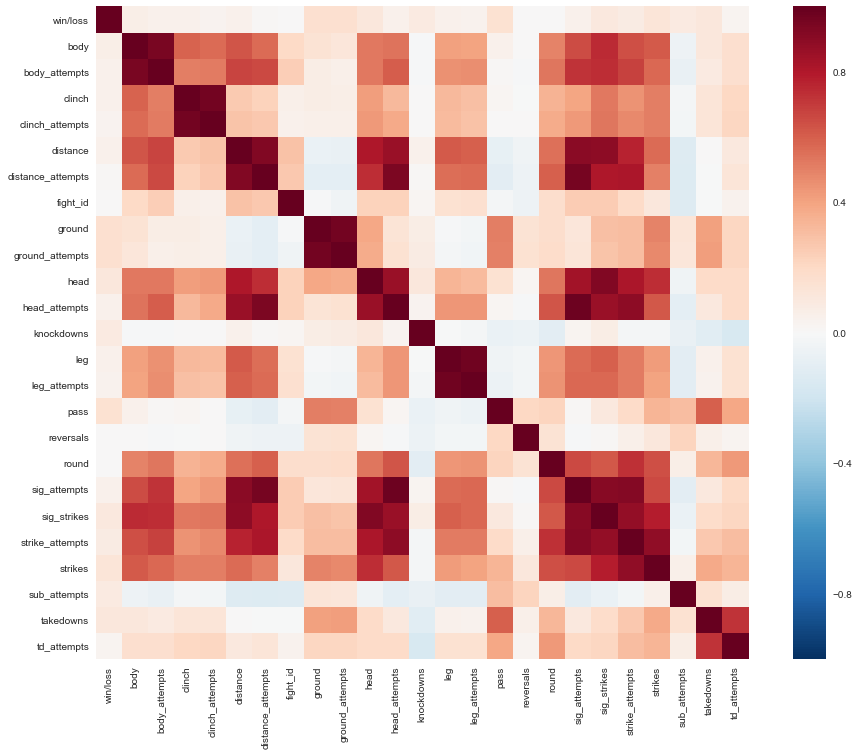

In [17]:
corrmat = fight_df.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corrmat, square=True)
plt.show()

Wow, there appears to be a strong corrleation between every strike and strike attempt. Wayne Gretsky was right, "You miss 100% of the shots you don't take." There are several other related variables scattered throughout the dataset. It seems significant attempts, head attempts and distance attempts are all closely related. Also of note is the relationship between the number of passes and the number of takedowns. Interestingly, the number of knowckdowns does not seem to be strongly correlated with any particular variable. There is a small connection between knockdowns, win/loss and head strikes.

There does not appear to be a lot of negative correlations. The only small standouts are sub attempts to fight_id, knockdowns to takedown attempts and sub attempts to distance strikes. The last two make sense to a certain extent. If a a fighter is a good striker, they'd have little reason to try to take someone their opponent down and if they're they're a submission artist they would probably throw fewer distance strikes. The relationship between sub attempts and fight_id doesn't make as much sense to me right now. In the beginning, not many people were familiar with bjj so I would expect the number of submission attempts to grow over time. I'll have to take a closer look at that later.

Applying a log transform yields...

In [18]:
fight_logs = fight_df.copy()
fight_logs.loc[:, cols] = fight_df[cols] + 1
fight_logs.loc[:, cols] = fight_logs[cols].apply(np.log)

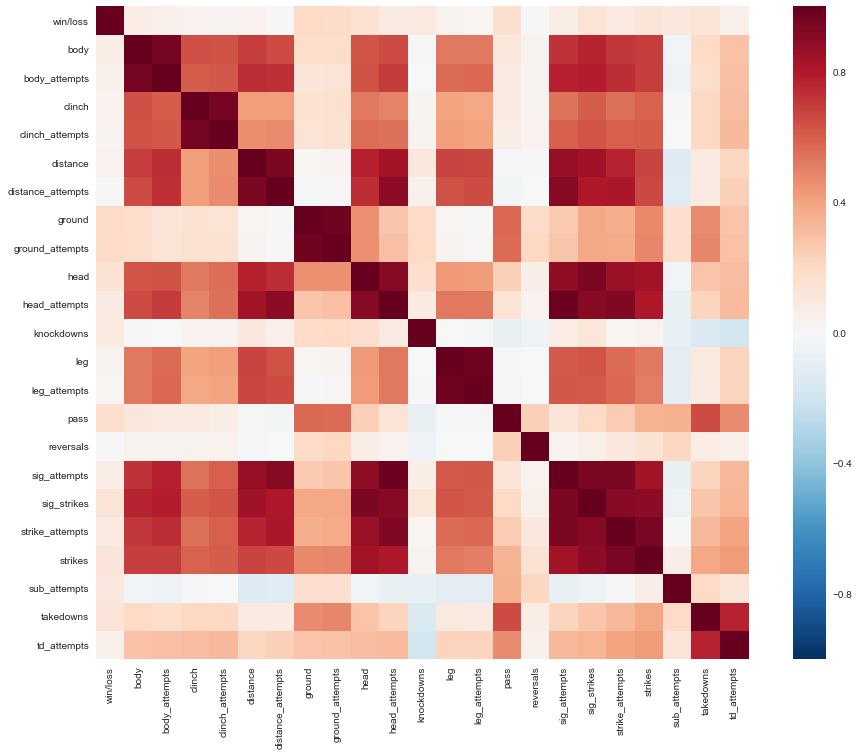

In [19]:
corrmat = fight_logs.drop(['fight_id', 'round'], axis=1).corr()
plt.figure(figsize=(16,12))
sns.heatmap(corrmat, square=True)
plt.show()

And creating a heatmap from the differences between each fighter yields...

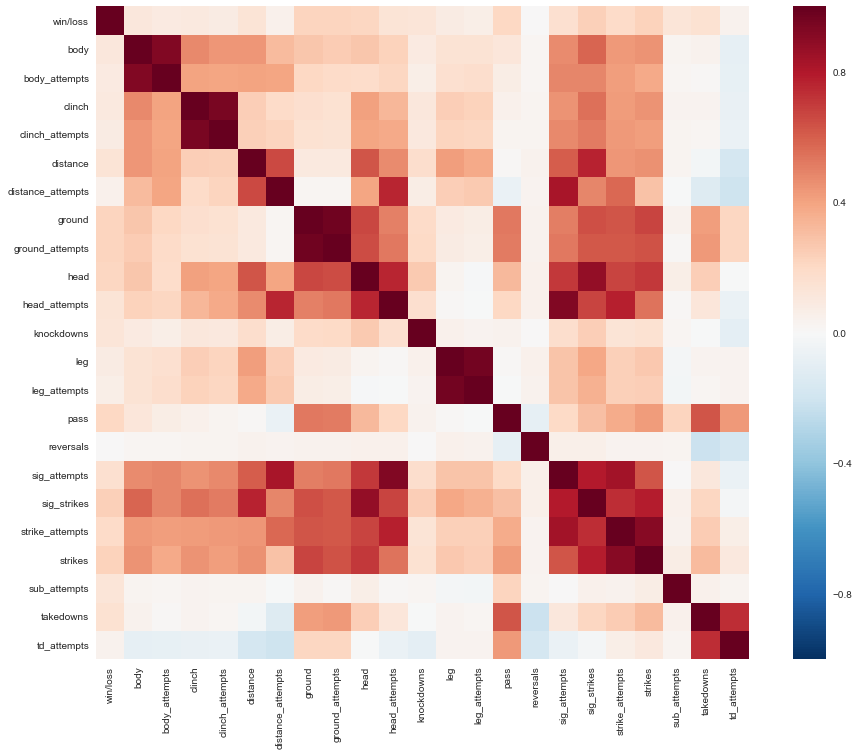

In [20]:
corrmat = fight_diffs.drop(['fight_id', 'round'], axis=1).corr()
plt.figure(figsize=(16,12))
sns.heatmap(corrmat, square=True)
plt.show()

### Strike Targets

I want to go through each of these variables to get a sense of each one. We'll use histograms, distribution plots, barplots, violin plots heatmaps, and more to get a better feel for the data.

#### Body

First up is body strikes.

In [ ]:
fight_df.body.describe()

In [ ]:
#upper_limit = np.percentile(fight_df['body'].values, 99)
#fight_df.loc[fight_df.body>upper_limit, 'body'] = upper_limit
plt.figure(figsize=(12,8))
plt.hist(
    'body',
    data=fight_df[fight_df['win/loss']==1],
    log=True,
    bins=50,
    alpha=.2,
    color='b'
)
plt.hist(
    'body',
    data=fight_df[fight_df['win/loss']==0],
    log=True,
    bins=50,
    alpha=.2,
    color='r'
)
plt.xlabel('Body Strikes')
plt.ylabel('Frequency')
plt.show()

It might make sense to plot the number of body strikes vs attempts since they may be correlated. Let's see what the data looks like.

In [ ]:
#upper_limit = np.percentile(fight_df['body'].values, 99)
#fight_df.loc[fight_df.body>upper_limit, 'body'] = upper_limit
plt.figure(figsize=(12,8))
plt.hist(
    'body',
    data=fight_winner,
    log=True,
    bins=50,
    alpha=.2,
    color='b'
)
plt.hist(
    'body',
    data=fight_loser,
    log=True,
    bins=50,
    alpha=.2,
    color='r'
)
plt.xlabel('Body Strikes')
plt.ylabel('Frequency')
plt.show()

In [ ]:
fight_df[fight_df.body>58]

In [ ]:
#upper_limit = np.percentile(fight_df['body_attempts'].values, 99)
#fight_df.loc[fight_df.body>upper_limit, 'body_attempts'] = upper_limit
#plt.figure(figsize=(12,8))
sns.lmplot('body_attempts', 'body', 
           data=fight_df, 
           scatter_kws={'alpha':.3},
           hue='win/loss',
           palette='Set1',
           size=9, 
           aspect=1.3)
plt.xlabel("Body Strike Attempts")
plt.ylabel("Body Strikes")
plt.show()

In [ ]:
#upper_limit = np.percentile(fight_df['body_attempts'].values, 99)
#fight_df.loc[fight_df.body>upper_limit, 'body_attempts'] = upper_limit
#plt.figure(figsize=(12,8))
sns.lmplot('body_attempts', 'body', 
           data=fight_diffs, 
           scatter_kws={'alpha':.3},
           hue='win/loss',
           palette='Set1',
           size=9, 
           aspect=1.3)
plt.xlabel("Body Strike Attempts")
plt.ylabel("Body Strikes")
plt.show()

Body strikes and body strike attempts are definitely positively correlated. I'm guessing it'll be the same for the other categories. Let's take a look.

#### Head

In [ ]:
fight_df['head'].describe()

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(
    'head',
    data=fight_df[fight_df['win/loss']==1],
    log=True,
    bins=50,
    alpha=.2,
    color='b'
)
plt.hist(
    'head',
    data=fight_df[fight_df['win/loss']==0],
    log=True,
    bins=50,
    alpha=.2,
    color='r'
)
plt.xlabel('Head Strikes')
plt.ylabel('Frequency')
plt.show()

In [ ]:
upper_landed = np.percentile(fight_df['head'].values, 99)
#fight_df.loc[fight_df['head']>upper_landed, 'head'] = upper_landed
upper_attempts = np.percentile(fight_df['head_attempts'].values, 99)
#fight_df.loc[fight_df.head_attempts>upper_attempts, 'head_attempts'] = upper_attempts
sns.jointplot(
    'head_attempts', 
    'head', 
    data=fight_df[(fight_df['head']<upper_landed) & (fight_df.head_attempts<upper_attempts)], 
    size=9, 
    kind='hex',
    color=color[3]
)
plt.show()

In [ ]:
# plt.figure(figsize=(12,8))
sns.lmplot(
    'head_attempts',
    'head',
    data=fight_df,
    hue='win/loss',
    palette='Set1',
    scatter_kws={'alpha':.3},
    fit_reg=False,
    size=9,
    aspect=2
)
plt.show()

In [ ]:
# plt.figure(figsize=(12,8))
sns.lmplot(
    'head_attempts',
    'head',
    data=fight_diffs,
    hue='win/loss',
    palette='Set1',
    scatter_kws={'alpha':.3},
    fit_reg=False,
    size=9,
    aspect=1.4
)
plt.show()

#### Leg

In [ ]:
fight_df.leg.describe()

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(
    'leg',
    data=fight_df[fight_df['win/loss']==1],
    log=True,
    bins=50,
    alpha=.2,
    color='b'
)
plt.hist(
    'leg',
    data=fight_df[fight_df['win/loss']==0],
    log=True,
    bins=50,
    alpha=.2,
    color='r'
)
plt.xlabel('Leg Strikes')
plt.ylabel('log(Frequency)')
plt.show()

In [ ]:
sns.jointplot('leg_attempts', 'leg', data=fight_df, size=9, alpha=.2, color=color[3])
plt.show()

In [ ]:
sns.lmplot(
    'leg_attempts',
    'leg',
    data=fight_diffs,
    hue='win/loss',
    palette='Set1',
    scatter_kws={'alpha':.3},
#     fit_reg=False,
    size=9,
    aspect=1.3
)
plt.show()

### Strike Types

#### Ground and Pound

Let's take a look at the number of ground strikes attempted and landed across the distribution.

In [ ]:
fight_df.ground.describe()

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(
    'ground',
    data=fight_df[fight_df['win/loss']==1],
    log=True,
    bins=50,
    alpha=.2,
    color='b'
)
plt.hist(
    'ground',
    data=fight_df[fight_df['win/loss']==0],
    log=True,
    bins=50,
    alpha=.2,
    color='r'
)
plt.xlabel('Ground and Pound')
plt.ylabel('log(Frequency)')
plt.show()

In [ ]:
temp_df = fight_df[['ground_attempts', 'ground']]
sns.jointplot(temp_df.ground_attempts, temp_df.ground, size=9, alpha=.1, color=color[3])
plt.show()

In [ ]:
sns.lmplot(
    'ground_attempts',
    'ground',
    data=fight_diffs,
    hue='win/loss',
    palette='Set1',
    scatter_kws={'alpha':.3},
    fit_reg=False,
    size=9,
    aspect=1.5
)
plt.show()

#### Distance

In [ ]:
fight_df.distance.describe()

That's quite a range! The mean is 19 but someone landed 228 strikes from distance. I would not want to be on the receiving end of that. Let's take a look at how the distance strikes landed line up with the distance strike attempts.

In [ ]:
upper_landed = np.percentile(fight_df['distance'].values, 99)
# fight_df.loc[fight_df.distance>upper_landed, 'distance'] = upper_landed
upper_attempts = np.percentile(fight_df['distance_attempts'].values, 99)
# fight_df.loc[fight_df.distance_attempts>upper_attempts, 'distance_attempts'] = upper_attempts
sns.jointplot(
    'distance_attempts', 
    'distance', 
    data=fight_df[(fight_df.distance<upper_landed)&(fight_df.distance_attempts<upper_attempts)], 
    kind='hex', 
    size=9, 
    color='r'
)
plt.show()

In [ ]:
sns.lmplot(
    'distance_attempts',
    'distance',
    data=fight_diffs,
    hue='win/loss',
    palette='Set1',
    scatter_kws={'alpha':.3},
    fit_reg=False,
    size=9,
    aspect=1.5
)
plt.show()

#### Clinch

In [ ]:
fight_df.clinch.describe()

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(
    'clinch',
    data=fight_df[fight_df['win/loss']==1],
    log=True,
    bins=50,
    alpha=.2,
    color='b'
)
plt.hist(
    'clinch',
    data=fight_df[fight_df['win/loss']==0],
    log=True,
    bins=50,
    alpha=.2,
    color='r'
)
plt.xlabel('Clinch')
plt.ylabel('log(Frequency)')
plt.show()

The distribution of successful clinch strikes is highly right-skewed, which makes it a good candidate for a log scale. Plotting clinch attempts vs clinch strikes shows that the data is highly correlated as well. With an r-value of .97, we can see that the number of clinch strikes highly depends on the number of attempts.

In [ ]:
sns.jointplot('clinch_attempts', 'clinch', data=fight_df, alpha=.1, size=9, color='r')
plt.show()

In [ ]:
sns.lmplot(
    'clinch_attempts',
    'clinch',
    data=fight_diffs,
    hue='win/loss',
    palette='Set1',
    scatter_kws={'alpha':.3},
    fit_reg=False,
    size=9,
    aspect=1.2
)
plt.show()

#### Significant Strikes

In [ ]:
fight_df.sig_strikes.describe()

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(
    'sig_strikes',
    data=fight_df[fight_df['win/loss']==1],
    log=True,
    bins=50,
    alpha=.2,
    color='b'
)
plt.hist(
    'sig_strikes',
    data=fight_df[fight_df['win/loss']==0],
    log=True,
    bins=50,
    alpha=.2,
    color='r'
)
plt.xlabel('Significant Strikes')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(
    'sig_strikes',
    data=fight_winner,
    #log=True,
    bins=50,
    alpha=.2,
    color='b'
)
plt.hist(
    'sig_strikes',
    data=fight_loser,
    #log=True,
    bins=50,
    alpha=.2,
    color='r'
)
plt.xlabel('Significant Strikes')
plt.ylabel('Frequency')
plt.show()

In [ ]:
upper_landed = np.percentile(fight_df['sig_strikes'].values, 99)
# fight_df.loc[fight_df['sig_strikes']>upper_landed, 'sig_strikes'] = upper_landed
upper_attempts = np.percentile(fight_df['sig_attempts'].values, 99)
# fight_df.loc[fight_df.sig_attempts>upper_attempts, 'sig_attempts'] = upper_attempts
sns.jointplot(
    'sig_attempts', 
    'sig_strikes', 
    data=fight_df[(fight_df.sig_strikes<upper_landed)&(fight_df.sig_attempts<upper_attempts)], 
    size=9, 
    kind='hex', 
    color='r')
plt.show()

In [ ]:
sns.lmplot(
    'sig_attempts',
    'sig_strikes',
    data=fight_diffs,
    hue='win/loss',
    palette='Set1',
    scatter_kws={'alpha':.3},
    fit_reg=False,
    size=9,
    aspect=1.5
)
plt.show()

#### Overall Strikes

In [ ]:
fight_df.strikes.describe()

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(
    'strikes',
    data=fight_df[fight_df['win/loss']==1],
    log=True,
    bins=50,
    alpha=.2,
    color='b'
)
plt.hist(
    'strikes',
    data=fight_df[fight_df['win/loss']==0],
    log=True,
    bins=50,
    alpha=.2,
    color='r'
)
plt.xlabel('Strikes')
plt.ylabel('Frequency')
plt.show()

In [ ]:
upper_landed = np.percentile(fight_df['strikes'].values, 99)
# fight_df.loc[fight_df['strikes']>upper_landed, 'strikes'] = upper_landed
upper_attempts = np.percentile(fight_df['strike_attempts'].values, 99)
# fight_df.loc[fight_df.strike_attempts>upper_attempts, 'strike_attempts'] = upper_attempts
sns.jointplot(
    'strike_attempts', 
    'strikes', 
    data=fight_df[(fight_df.strikes<upper_landed)&(fight_df.strike_attempts<upper_attempts)], 
    size=9, 
    kind='hex', 
    color='r')
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(
    'strikes',
    data=fight_winner,
    log=True,
    bins=50,
    alpha=.2,
    color='b'
)
plt.hist(
    'strikes',
    data=fight_loser,
    log=True,
    bins=50,
    alpha=.2,
    color='r'
)
plt.xlabel('Strikes')
plt.ylabel('Frequency')
plt.show()

In [ ]:
sns.lmplot(
    'strike_attempts',
    'strikes',
    data=fight_diffs,
    hue='win/loss',
    palette='Set1',
    scatter_kws={'alpha':.3},
    fit_reg=False,
    size=9,
    aspect=1.2
)
plt.show()

### Grappling

#### Submissions

This variable will require a bit of reworking. The submission variable is binary, while the submissions attempted is discrete. That makes sense of course, becaues you can't submit someone more than once in a match by definition (unless you count twitter wars). So for this aspect, let's take at the distribution of submissions attempts vs the method used. My theory is that submission attempts are higher in fights that end that way, but let's take a look at the data!

In [ ]:
upper_attempts = np.percentile(fight_df.sub_attempts, 99)
plt.figure(figsize=(12,8))
sns.violinplot(
    x="method", 
    y="sub_attempts", 
    data=fight_df[(fight_df.sub_attempts<upper_attempts)])
plt.show()

What an interesting distribution! And just as expected, fights that end in submission have a higher percentage of submisssion attempts greater than zero. Interestingly, fights that end in decision aren't heavy on submission attempts. This could be due to the nature of how fights are scored overall since submission attempts do not give a fighter as many points as strikes.

Another thing that jumped out at me is the number of submission wins with zero submission attempts. I would expect that every fight that ends in submission contained at least one submission attempt, but I'm guessing they count submission due to strikes as well.

#### Passes

In [ ]:
w_counts = fight_df.loc[fight_df['win/loss']==1,'pass'].value_counts()
l_counts = fight_df.loc[fight_df['win/loss']==0,'pass'].value_counts()
plt.figure(figsize=(12,8))
plt.bar(
    w_counts.index,
    w_counts.values,
    alpha=.3,
    color='b'
)
plt.bar(
    l_counts.index,
    l_counts.values,
    alpha=.3,
    color='r'
)
plt.xlabel('Passes')
plt.ylabel('Frequency')
'''
for x,y in zip(counts.index, counts.values):
    plt.text(x, y, y, ha='center', va='bottom')
'''
plt.show()

#### Reversals

In [ ]:
w_counts = fight_df.loc[fight_df['win/loss']==1,'reversals'].value_counts()
l_counts = fight_df.loc[fight_df['win/loss']==0,'reversals'].value_counts()
plt.figure(figsize=(12,8))
plt.bar(
    w_counts.index,
    w_counts.values,
    alpha=.3,
    color='b'
)
plt.bar(
    l_counts.index,
    l_counts.values,
    alpha=.3,
    color='r'
)
plt.xlabel('Reversals')
plt.ylabel('Frequency')
'''
for x,y in zip(counts.index, counts.values):
    plt.text(x, y, y, ha='center', va='bottom')
'''
plt.show()

#### Takedowns

In [ ]:
w_counts = fight_df.loc[fight_df['win/loss']==1,'takedowns'].value_counts()
l_counts = fight_df.loc[fight_df['win/loss']==0,'takedowns'].value_counts()
plt.figure(figsize=(12,8))
plt.bar(
    w_counts.index,
    w_counts.values,
    alpha=.3,
    color='b'
)
plt.bar(
    l_counts.index,
    l_counts.values,
    alpha=.3,
    color='r'
)
plt.xlabel('Takedowns')
plt.ylabel('Frequency')
plt.show()

In [ ]:
upper_landed = np.percentile(fight_df['takedowns'].values, 99)
upper_attempts = np.percentile(fight_df['td_attempts'].values, 99)
sns.jointplot(
    'td_attempts', 
    'takedowns', 
#     data=fight_df[(fight_df.takedowns<=upper_landed)&(fight_df.td_attempts<=upper_attempts)],
    data=fight_df,
    size=9,
    alpha=.1,
    color=color[1])
#     kind='hex',
#     marginal_kws={'bins':50})
plt.show()

### Knockdowns

In [ ]:
w_counts = fight_df.loc[fight_df['win/loss']==1,'knockdowns'].value_counts()
l_counts = fight_df.loc[fight_df['win/loss']==0,'knockdowns'].value_counts()
plt.figure(figsize=(12,8))
plt.bar(
    w_counts.index,
    w_counts.values,
    alpha=.3,
    color='b'
)
plt.bar(
    l_counts.index,
    l_counts.values,
    alpha=.3,
    color='r'
)
plt.xlabel('Knockdowns')
plt.ylabel('Frequency')
plt.show()

### Referees and Fighters

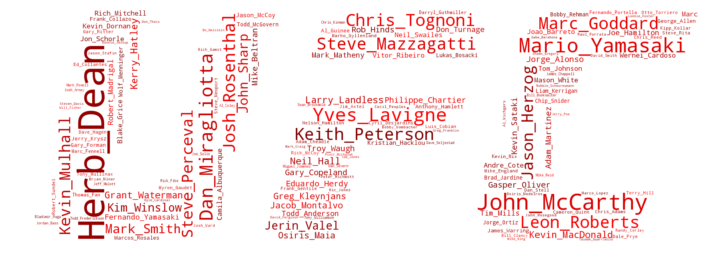

In [21]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 100%, {}%)".format(random.randint(25, 50))

# Extract referee text from fight_df
text = " ".join("_".join(ref.split()) for ref in fight_df[fight_df.referee.notnull()].referee.tolist())

# read the mask image
ufc_mask = np.array(Image.open("images/UFC_Logo.png"))

wc = WordCloud(background_color="white", mask=ufc_mask, random_state=42)
# generate word cloud
wc.generate(text)

wc.recolor(color_func=grey_color_func, random_state=3)

# store to file
wc.to_file("images/ufc_red_wordcloud.png")

# show
plt.figure(figsize=(12,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

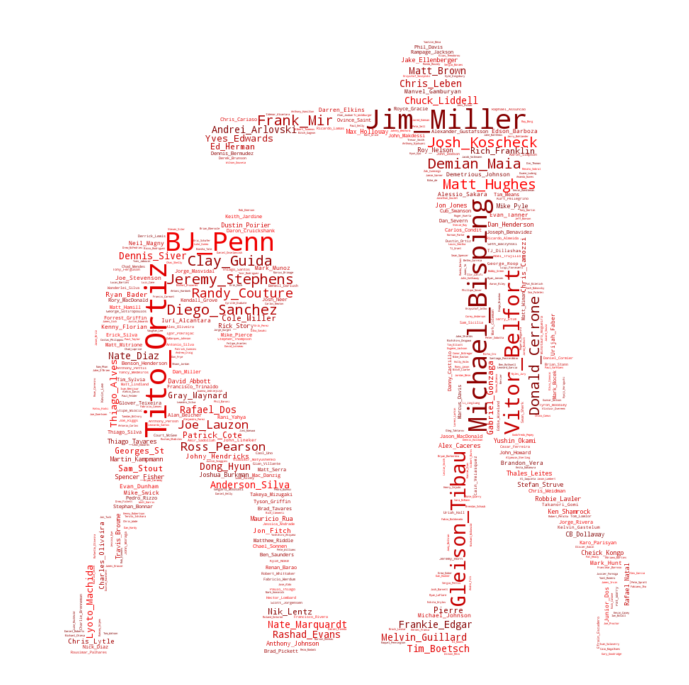

In [22]:
def custom_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 100%, {}%)".format(random.randint(25, 50))

# Extract referee text from fight_df
text = " ".join("_".join(fighter.split()) for fighter in fight_df[fight_df.name.notnull()].name.tolist())

# read the mask image
fighter_mask = np.array(Image.open("images/shadowboxing.jpg"))


wc = WordCloud(max_words=1000, background_color="white", mask=fighter_mask, random_state=1)
# generate word cloud
wc.generate(text)

wc.recolor(color_func=custom_color_func, random_state=3)

# store to file
wc.to_file("images/ufc_fighter_red_wordcloud.png")

# show
plt.figure(figsize=(14,12))
plt.imshow(wc.recolor(color_func=custom_color_func, random_state=3), interpolation='bilinear')
plt.axis("off")
plt.show()

### Rounds

Finally, let's see how the rounds are distributed. A fight can end in any round, but the maximum number of rounds for each fight depends on whether it's a title fight. Title fights are 5 rounds long while non-title fights are 3 rounds long.

In [ ]:
counts = fight_df['round'].value_counts()
plt.figure(figsize=(12,8))
plt.bar(counts.index, counts.values, alpha=.7, color='g')
plt.xlabel('Round')
plt.ylabel('Frequency')
for x,y in zip(counts.index, counts.values):
    plt.text(x, y, y, ha='center', va='bottom')
plt.show()

Very interesting. The most frequent fight length was 3 rounds while the least frequent was 4. This tells me that most fights probably go to a decision rather than KO or submission. Let's take a look at the data!

### Method

In [ ]:
fight_df['method'].value_counts()

The first thing that jumps out at me is the "Could" category. I have no idea what that represents. I'm guessing it's a typo but I'll have to do some research to see what's going on there. I'll also check out what the "Other" category might represent.

Most fights end in either Decision, KO/TKO or Submission. The categories below that are in such small quantities that I'd call them outliers to be removed. There's no way to predict whether a fight will be overturned or whether a fighter will get DQ'd, so it makes no sense to include those categories.

I wonder why they separated KO/TKO and TKO into two separate groups? That seems worth researching to see if maybe we can consolidate the two categories.

In [ ]:
fight_df[fight_df.method=='Could'].iloc[-10:, :5]

In [ ]:
fight_df[fight_df.method=='Other'].iloc[:, :5]

In [ ]:
fight_df[fight_df.method=='TKO'].iloc[-10:, :5]

After doing a little market research and totally not wasting time by watching UFC fights, it looks like the "Could" category stands for no contest, "Other" stands for draws and "TKO" stands for fights where one fighter could not continue due to injury. Each of these scenarios present different challenges. Before going further, let's change "Could" to "No Contest", "Other" to "Draw" and change TKO to "Injury".

In [ ]:
fight_df.loc[fight_df.method=='Could', 'method'] = "No Contest"
fight_df.loc[fight_df.method=='TKO', "method"] = "Injury"
fight_df.loc[fight_df.method=='Other', "method"] = "Draw"

Fights that stop due to injury are usually fights in which one fighter has been beating his opponent so badly, they had to stop the fight because the opponent couldn't continue. I'll probably do some more market research later, but right now I see that as a win. The goal is to beat up the other fighter, so mission accomplished. I don't know if I'll combine that category with TKO/KO's, but it's a valid win.

No contests and draws, however are a different story. Neither one demonstrates that one side dominated the other and in many cases they are the result of luck. Because of this, they will most likely be dropped from the dataset before building any models.

In [ ]:
counts = fight_df['method'].value_counts()
plt.figure(figsize=(12,8))
plt.bar(range(len(counts.index)), counts.values, alpha=.7)
plt.xlabel('Method')
plt.ylabel('Frequency')
plt.xticks(range(len(counts.index)), counts.index)
for x,y in zip(range(len(counts.index)), counts.values):
    plt.text(x, y, y, ha='center', va='bottom')
plt.show()

## Data Cleaning

The first step in data cleaning is to remove obvious outliers and columns that will not contribute to the model. One starting point is narrowing down the fights to just Decisions, TKO/KOs and submissions, excluding the minor categories. No contests are nearly impossible to predict as are draws, so it doesn't make sense to account for them. Here's a list of ideas so far:

1. Drop no contests, DQ's, draws, etc
2. Create accuracy percentages where appropriate
3. Keep a running tally of each fighter's record (wins/losses)

### Dropping No Contests, DQ's, etc

In [ ]:
unwanted = ['Overturned', 'No Contest', 'DQ', 'Draw']
for val in unwanted:
    fight_df = fight_df[fight_df['method']!=val]

In [ ]:
fight_df['method'].value_counts()

### Checking for NaN's

In [ ]:
fight_diffs[fight_diffs.isnull().any(axis=1)]

In [ ]:
fight_diffs[fight_diffs.isnull().any(axis=1)]

### Extracting Country from B_Location and R_Location

I want to extract each figher's country location. Currently there are 438 unique locations in the dataset. This is too many categories to get a sense of where fighters are training. There may also be some correlation between a fighter's location and his or her record. The first thing I did was exclude any fighters with null values for their current location. Thankfully, there were only 8 such cases. Then I cleaned up some of the mispellings / duplicate entries (USA and United States were consolidated into just USA). Finally, I replaced all [City Country] values to [Country] values.

In [ ]:
data['B_Location'].value_counts()[:10]

In [ ]:
data = data[data['winby'].notnull()]
loc_data = data[(data['B_Location'].notnull()) & data['R_Location'].notnull()]
data = data[data['winner'] != 'no contest']
#data = data.reset_index()

In [ ]:
count = loc_data['B_Location'].str.split().apply(len).value_counts()
count.index = count.index.astype(str) + ' words:'
count.sort_index(inplace=True)
count

In [ ]:
len(loc_data)
len(data)

In [ ]:
locations = ['B_Location', 'R_Location']
countries = ['Japan','Singapore']
for location in locations:
    for country in countries:
        loc_data.loc[(loc_data[location] == country), location] = 'Unknown '+country

In [ ]:
# This script cleans up mispellings and extracts country info from city country columns
locations = ['B_Location', 'R_Location']
new_cols = ['R_Country_Location', 'B_Country_Location']

c_dict = {
    'United': 'USA',
    'Brasil': 'Brazil',
    'Englad': 'England',
    'Czech': 'CzechRepublic',
    'Moldova': 'Moldova',
}

post_c_dict = {
    'Africa': 'South Africa',
    'CzechRepublic': 'Czech Republic',
    'PAN': 'Panama',
    'Zealand': 'New Zealand'
}
countries = ['']
for location in locations:
    for k,v in c_dict.items():
        loc_data.loc[loc_data[location].str.contains(k), location] = v

for new_col, location in zip(new_cols, locations):
    loc_data[new_col] = loc_data[location].str.split().str[-1]
for col in new_cols:
    for k,v in post_c_dict.items():
        loc_data.loc[loc_data[col].str.contains(k), col] = v

for location, col in zip(locations, new_cols):
    loc_data[location] = loc_data[col]
    del loc_data[col]
sorted(set(loc_data['B_Location'].values.tolist()))

In [ ]:
loc_data['B_Location'].value_counts()

In [ ]:
dropdata = data.drop(['B_ID','B_Name','R_ID','R_Name','Date'],axis=1)
dropdata.rename(columns={'BPrev':'B__Prev',
                         'RPrev':'R__Prev',
                         'B_Age':'B__Age',
                         'B_Height':'B__Height',
                         'B_Weight':'B__Weight',
                         'R_Age':'R__Age',
                         'R_Height':'R__Height',
                         'R_Weight':'R__Weight',
                         'BStreak':'B__Streak',
                         'RStreak': 'R__Streak'},inplace=True)
dropdata.describe()

### Converting Strings to Categories

Next we need to convert our object types of columns into categorical columns. This is done to sort by logical order

In [ ]:
objecttypes = list(dropdata.select_dtypes(include=['O']).columns)
for col in objecttypes:
    dropdata[col] = dropdata[col].astype('category')

In [ ]:
cat_columns = dropdata.select_dtypes(['category']).columns
dropdata[cat_columns] = dropdata[cat_columns].apply(lambda x: x.cat.codes)
dropdata.info()
dropdata.tail()

## Feature Engineering

What is it about each figher that makes him a favorite? This may require a lot or rearranging, so it may be worth it to think this through a bit first. I could reset each fighter's stats and only add stats that came prior to each fight. This would be a more comprehensive way of comparing each fighter and would align more closely to real-world applications. Here's a rough sketch of what the process might look like:

1. Add columns for kicks taken, punches taken, etc?
  1. One disadvantage is that this would mean nearly doubling the number of variables in a dataset that is already massive. This will hurt some machine learning models. Let's omit this for now and come back to it later if necessary.

## Modeling

We're going to be methodical when building and testing our algorithms. It's easy to run in circles due to the plethora of algorithms and parameters available. Is a decision tree a better choice? Or should we try Random Forest? What about Support Vector Machines? The machines need our support! Rather than going through all these possibilities and forgetting the results, we'll build pipelines and document our process as we go along. By staying organized, it will be easier to tell if we've already tried a solution. It may also serve to highlight the desired path a bit (one can only hope).

Here's a list of models we have so far. We may add to this list, but it's a good starting place.

1. Perceptron
2. Random Forests
3. Decision Trees Classifier
4. SGD Classifier
5. Linear SVC
6. Gaussian NB
7. KNN

Of course, machine learning isn't just about finding that perfect algorithm. The results depend heavily on earlier steps in the process. One might even say that most of the accuracy depends on the exploratory analysis and feature engineering. That's why so much time was spent in that phase.

Now that we have a few algorithms to explore, we'll pay close attention to each one's hyperparameters. If the data is unbalanced, we'll need to account for that and if it's overfitting / underfitting, we may have to make a different set of changes. There's a lot to absorb here. Let's take our time and keep in mind that data analysis is not a linear process. Sometimes we have to go back and forth between modeling, wrangling, exploring and feature engineering. We can't be afraid to get our hands dirty!

In [ ]:
numerical_diffs = fight_diffs.drop(['name', 'method', 'fight_id', 'referee', 'round'], axis=1)

In [ ]:
# help(sklearn.ensemble.RandomForestClassifier())
# help(sklearn.naive_bayes.GaussianNB)
# help(sklearn.svm.LinearSVC)
# import sklearn
# help(sklearn)

In [ ]:
# We Store prediction of each model in our dict
# Helper Functions for our models. 

def percep(X_train,Y_train,X_test,Y_test,Models):
    perceptron = Perceptron(max_iter = 1000, tol = 0.001, random_state=42)
    perceptron.fit(X_train, Y_train)
    Y_pred = perceptron.predict(X_test)
    Models['Perceptron'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def ranfor(X_train,Y_train,X_test,Y_test,Models):
    randomfor = RandomForestClassifier(max_features="sqrt",
                                       n_estimators = 700,
                                       max_depth = None,
                                       n_jobs=-1,
                                       random_state=42
                                      )
    randomfor.fit(X_train,Y_train)
    Y_pred = randomfor.predict(X_test)
    Models['Random Forests'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def dec_tree(X_train,Y_train,X_test,Y_test,Models):
    decision_tree = DecisionTreeClassifier(random_state=42)
    decision_tree.fit(X_train, Y_train)
    Y_pred = decision_tree.predict(X_test)
    Models['Decision Tree'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def SGDClass(X_train,Y_train,X_test,Y_test,Models):
    sgd = SGDClassifier(max_iter = 1000, tol = 0.001, random_state=42)
    sgd.fit(X_train, Y_train)
    Y_pred = sgd.predict(X_test)
    Models['SGD Classifier'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def linSVC(X_train,Y_train,X_test,Y_test,Models):
    linear_svc = LinearSVC(random_state=42)
    linear_svc.fit(X_train, Y_train)
    Y_pred = linear_svc.predict(X_test)
    Models['SVM'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def bayes(X_train,Y_train,X_test,Y_test,Models):
    gaussian = GaussianNB()
    gaussian.fit(X_train, Y_train)
    Y_pred = gaussian.predict(X_test)
    Models['Bayes'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def Nearest(X_train,Y_train,X_test,Y_test,Models):
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    Models['KNN'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]

def run_all_and_Plot(df):
    Models = dict()
    from sklearn.model_selection import train_test_split
    X_all = df.drop(['win/loss'], axis=1)
    y_all = df['win/loss']
    X_train, X_test, Y_train, Y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=0)
    percep(X_train,Y_train,X_test,Y_test,Models)
    ranfor(X_train,Y_train,X_test,Y_test,Models)
    dec_tree(X_train,Y_train,X_test,Y_test,Models)
    SGDClass(X_train,Y_train,X_test,Y_test,Models)
    linSVC(X_train,Y_train,X_test,Y_test,Models)
    bayes(X_train,Y_train,X_test,Y_test,Models)
    Nearest(X_train,Y_train,X_test,Y_test,Models)
    return Models


def plot_bar(dict):
    labels = tuple(dict.keys())
    y_pos = np.arange(len(labels))
    values = [dict[n][0] for n in dict]
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, labels,rotation='vertical')
    plt.ylabel('accuracy')
    plt.title('Accuracy of different models')
    plt.show()


def plot_cm(dict):
    count = 1
    fig = plt.figure(figsize=(10,10))
    for model in dict:
        cm = dict[model][1]
        labels = ['W','L']
        ax = fig.add_subplot(4,4,count)
        cax = ax.matshow(cm)
        plt.title(model,y=-0.8)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        # plt.subplot(2,2,count)
        count+=1
    plt.tight_layout()
    plt.show()

In [ ]:
accuracies = run_all_and_Plot(numerical_diffs.iloc[:,:7])
CompareAll = dict()
CompareAll['Baseline'] = accuracies
for key,val in accuracies.items():
    print(str(key) +' '+ str(val[0]))
plot_bar(accuracies)
plot_cm(accuracies)

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
#X_all = dropdata.drop(['winner'], axis=1)
#y_all = dropdata['winner']
#X_train, X_test, Y_train, Y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=23)
#rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True, max_depth=None) 
#param_grid = { 
#    'n_estimators': [200,700],
#    'max_features': ['auto', 'sqrt', 'log2']
#}

#CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
#CV_rfc.fit(X_train, Y_train)
#print(CV_rfc.best_params_)

### Trying to improve results by dividing features

This block turns each individual red and blue round stat into a ratio of red to blue values. It divides the number of features from 895 to 450. For instance, it turns R_Round4_Strikes_Kicks_Landed and B_Round4_Strikes_Kicks_Landed into a single ratio of red to blue strikes kicks landed. Interesting approach, it appears to be part of th iteration process to see what will be most effective in this analysis.

In [ ]:
dontchange = ['winner','Event_ID','Fight_ID','Max_round','Last_round','B_Age','R_Age']
numeric_cols = [col for col in dropdata if col not in dontchange]
dropdata[numeric_cols] += 1 

In [ ]:
newDF = dropdata.copy()
blue_cols = [col for col in dropdata.columns if 'B__' in col]
red_cols = [col for col in dropdata.columns if 'R__' in col]
for (blue,red) in zip(blue_cols,red_cols):
    newkey = ''.join(str(blue).split('_')[2:])
    dropdata[newkey] = dropdata[str(blue)]/dropdata[str(red)]
    del dropdata[str(blue)]
    del dropdata[str(red)]
newDF.head()

In [ ]:
accuracies = run_all_and_Plot(dropdata)
for key,val in accuracies.items():
    print(str(key) +' '+ str(val[0]))
CompareAll['Blue/Red'] = accuracies
plot_bar(accuracies)
plot_cm(accuracies)


### Dropping First Fights

This drops any fights in which the fighter has no previous recorded. I may use this in my model but again I'm hesitant to do so because it involves a huge loss of data. Looking at the original CSV, there are 342 records in for Red and 499 records for blue in which they have no previously recorded fight data. I can't afford to lose more than half the data.

This is actually a pretty interesting problem because I'm not sure how to deal with new fighters. By definition, their stats will show up as zeros if they don't have any fight data. It might be worth exploring how to get records prior to 2014 and going from there. Possible sources include:

1. Fightmetrics
2. Fight data from other fight organizations
3. Looking into what the original analyst meant when he said the previous data was not as granular

In [ ]:
data[data.RPrev == False]

In [ ]:
data[data.BPrev == False]

In [ ]:
blahblah = bewb[bewb.Prev != 1]
accuracies = run_all_and_Plot(blahblah)
for key,val in accuracies.items():
    print(str(key)+' '+str(val[0]))
CompareAll['DroppingDebut'] = accuracies
plot_bar(accuracies)
plot_cm(accuracies)

In [ ]:
blue_cols

### Aggregate Round Stats

This block sums the stats for each round into one value. For example, it combines round 1-5 strikes_landed into a single value. This is what I was thinking of doing. May have to borrow this code in my analysis.

In [ ]:
blue_cols
newDF.info()
b_feats = list(set([x[10:] for x in blue_cols if "Round" in x]))
r_feats = list(set([x[10:] for x in red_cols if "Round" in x]))
def sumshit(b_feats,cols):
    for x in b_feats:
        newDF.loc[:,x] = 0
        for y in cols:
            if x in y:
                newDF[x] += newDF[y]
                newDF.drop(y,axis=1,inplace=True)
sumshit(b_feats,blue_cols)
sumshit(r_feats,red_cols)
newDF.info()


In [ ]:
newDF.describe()
accuracies = run_all_and_Plot(newDF)
for key,val in accuracies.items():
    print(str(key) +' '+ str(val[0]))
CompareAll['SumRounds'] = accuracies
plot_bar(accuracies)
plot_cm(accuracies)



### Comparing Red to Blue

This block compares red stats to blue stats. It creates a ratio of strikes landed by red vs strikes landed by blue for each category. Very useful. I think I'm going to borrow this code as well since it's an idea I was thinking about implementing in my reanalysis.

In [ ]:
blue_cols = [col for col in newDF.columns if 'B__' in col]
red_cols = [col for col in newDF.columns if 'R__' in col]
for (blue,red) in zip(blue_cols,red_cols):
    newkey = ''.join(str(blue).split('_')[2:])
    newDF[newkey] = newDF[str(blue)]/newDF[str(red)]
    del newDF[str(blue)]
    del newDF[str(red)]

In [ ]:
accuracies = run_all_and_Plot(newDF)
for key,val in accuracies.items():
    print(str(key) +' '+ str(val[0]))
CompareAll['SumRounds'] = accuracies
plot_bar(accuracies)
plot_cm(accuracies)

### Reducing Features

This block drops features that are seemingly arbitrary and may have little effect on the data. It drops weight, hometown, event location, event id, fight id, max round and last round. Interestingly, the accuracy scores dip slightly after this is done. I'm not sure I agree with the decisions made here. For instance, I still want to take a look at splitting the columns by city and country. I'm not sure about the others. I'll have to combe back to this later down the road.

In [ ]:
reduced_features = newDF.drop(["Weight","B_HomeTown","B_Location", "Event_ID", "Fight_ID", "Max_round", "Last_round", "R_HomeTown", "R_Location"],axis = 1)
accuracies = run_all_and_Plot(reduced_features)
for key,val in accuracies.items():
    print(str(key) +' '+ str(val[0]))
CompareAll['Reduced Features'] = accuracies
plot_bar(accuracies)
plot_cm(accuracies)


In [ ]:
reduced_features.info()

In [ ]:
sorted(reduced_features.columns.values.tolist())

## Conclusion


## Stretch Goals

### Rewrite and re-run scraper to pull data from earlier years

It won't be as granular, but it may strengthen the analysis. There might not be enough records from 2014 onwards to model the data accurately. On the other hand, I'm not even sure the previous analyst modeled the data accurately. He took fight data from each fight and used that to predict the winner. That's not realistic. You don't have a round-by-round analysis before the fight happens! It would be much better to use the running totals to predict a fight's outcome. Looks like we're learning Beautiful Soup! At least you have a starting point.

## Scraper Rewrite

The data on fightmetric is more robust than the data on ufc.com. The data I'm getting from ufc.com has a lot of missing data in general and it does not break down each fight as well. It lists strike percentages but does not give raw numbers. The fightmetric data lists raw data as well as percentages and may lead to a more complete picture of each fighter. It also does not require as much merging. Looks like we're starting fresh!

### Fight URL Scraper

This first script pulls the urls of all fights from fightmetric.com and exports them as a CSV.

I want to add functionality to get the date, location and title of each fight event.

In [57]:
from bs4 import BeautifulSoup
import pandas as pd
import urllib
import os
os.chdir('/Users/courtneyfergusonlee/ufc_fight_analysis/data')

# Open the main page with events listed
sock = urllib.urlopen('http://www.fightmetric.com/statistics/events/completed?page=all')
page = sock.read()
soup = BeautifulSoup(page, "html.parser")

# Scrape event URLs from the main page
event_urls = []
event_dates = []
event_locations = []

trs = soup.find_all('tr')
for tr in trs:
    for link in tr.find_all('a'):
        event_urls.append(link.get('href'))
    
    for span in tr.find_all('span'):
        event_dates.append(" ".join(str(span.get_text()).split()))
    
    event_locations.append(" ".join(str((tr.find_all('td')[1].get_text()).split())))

print event_dates[:10]
print event_urls[:10]
print event_locations[:10]
# Pull Fight URLs, dates and locations from each Event URL
fight_urls = []
count = 0
for event_url, date, location in zip(event_urls, event_dates, event_locations): 
    if count==3:
        break
    print event_url, date, location
    try:
        sock = urllib.urlopen(event_url)
        event_html = sock.read()
        event_soup = BeautifulSoup(event_html, "html.parser")

        tds = event_soup.find_all('td')
        for td in tds:
            for link in td.find_all('a'):
                url = link.get('href')
                url_type = url.split('-')[0][-2:] # Fight vs. Fighter; last 2 letters
                if url_type == 'ht': # use er for fighter, ht for fight
                    #print url
                    fight_urls.append([url, date, location])
        
    
    except urllib2.HTTPError:
        print "HTTP Error"
        pass
    count += 1

# Save fight URLs to a csv file
fight_urls = pd.DataFrame(
    data=fight_urls, 
    columns=['link', 'date', 'location'])
fight_urls.to_csv('fight_urls.csv', index=False)



IndexError: list index out of range

In [45]:
fight_urls = pd.read_csv('data/fight_urls.csv')
for i in range(10):
    print fight_urls.iloc[-i, 0]

http://www.fightmetric.com/fight-details/d1bee15e60ee6721
http://www.fightmetric.com/fight-details/567a09fd200cfa05
http://www.fightmetric.com/fight-details/2d2bbc86e941e05c
http://www.fightmetric.com/fight-details/cecdc0da584274b9
http://www.fightmetric.com/fight-details/46acd54cc0c905fb
http://www.fightmetric.com/fight-details/ac7ca2ec38b96c1a
http://www.fightmetric.com/fight-details/ffd16691c4c4aafc
http://www.fightmetric.com/fight-details/00b0796724ec1c09
http://www.fightmetric.com/fight-details/64139d1d505e46c5
http://www.fightmetric.com/fight-details/4acab67848e78327


In [41]:
fight_urls[fight_urls.link.str.contains('eb300')]

,link
4363,http://www.fightmetric.com/fight-details/6ca94...


In [42]:
fight_urls.iloc[4363, 0]

'http://www.fightmetric.com/fight-details/6ca94b35719eb300'

In [44]:
len(fight_urls)*2

8826

In [ ]:
http://www.fightmetric.com/event-details/9211aae062b799d6

### Fight Scraper

This scrapes all fight data from fightmetric.com/fight-details. It reads a list of URLs, pulls the fight statistics from each fight, and concatenates it onto a Pandas dataframe. There are over 4000 urls in the list, so it takes a while to run (over 3 hours).

In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import urllib
import os
os.chdir('/Users/courtneyfergusonlee/ufc_fight_analysis/MMA-scraper-master')

# Load URLs from CSV (created in fight url scraper)
fight_urls = pd.read_csv('fight_urls.csv', encoding='utf-8')['link'].values.tolist()

# Initialize an empty dataframe
fighter_df = pd.DataFrame(columns=['name_first', 'name_last', 'kd', 'sig_strikes', 'sig_attempts', 'strikes', 'strike_attempts', 
                                   'takedowns', 'td_attempts', 'sub_attempts', 'pass', 'reversals', 'head', 'head_attempts', 'body', 
                                   'body_attempts','leg', 'leg_attempts', 'distance', 'distance_attempts', 'clinch', 'fight_id',
                                   'clinch_attempts', 'ground', 'ground_attempts', 'win/loss', 'referee', 'round', 'method',
                                   'date', 'location', 'title'])


# Iterate through the fight urls, and pull relevant variables/fields
for i in range(len(fight_urls)):
    if i==10:
        print i, fight_urls[i]
        break
    
    sock = urllib.urlopen(fight_urls[i]) # specific URL for a fight
    fight_html = sock.read()
    fight_soup = BeautifulSoup(fight_html, "html.parser")
    trs = fight_soup.find_all('tr') # all the tables in each fight URL
    headers = fight_soup.find_all('i')
    bad_call = 0
    try: 
        referee = str(headers[24].get_text()).split()[1] + ' ' + str(headers[24].get_text()).split()[-1]
    except:
        referee = None
    try:
        rounds = str(headers[18].get_text()).split()[1]
    except:
        rounds = None
    try:
        method = str(headers[17].get_text()).split()[0]
    except:
        method = None
    try:
        tr1 = str(trs[1].get_text()).split()
        # Find the location of the 2nd table tr2 (it varies)
        j = 0
        while j < 10:
            if str(trs[j].get_text()).split()[6] == 'Head':
                #print j+1
                tr2 = str(trs[j+1].get_text()).split()
                j = 10
            else:
                j += 1
        #print tr1; #print tr2
        
        # Test for the end of names
        k = 0
        while k < len(tr1):
            try:
                int(tr1[k])
                break
            except:
                k += 1
                continue
        #print k
    except:
        print str(i) + ' bad call' if i%20 == 0 else None
        bad_call += 1
        continue


    # Add each fighter's information to the dataframe
    fighter1 = pd.DataFrame({'name_first': tr1[:1], 'name_last': tr1[1:2], 'kd': tr1[k], 'sig_strikes': tr1[k+2],
    'sig_attempts': tr1[k+4], 'strikes': tr1[k+10], 'strike_attempts': tr1[k+12], 'takedowns': tr1[k+16],'td_attempts': tr1[k+18],
    'sub_attempts': tr1[k+24], 'pass': tr1[k+26], 'reversals': tr1[k+28], 'head': tr2[k+8], 'head_attempts': tr2[k+10],
    'body': tr2[k+14], 'body_attempts': tr2[k+16], 'leg': tr2[k+20], 'leg_attempts': tr2[k+22], 'distance': tr2[k+26],
    'distance_attempts': tr2[k+28], 'clinch': tr2[k+32], 'clinch_attempts': tr2[k+34], 'ground': tr2[k+38], 
    'ground_attempts': tr2[k+40], 'win/loss': 1, 'referee': referee, 'round': rounds, 'method': method, 'fight_id': i,
    'date': tr[x], 'location': tr[y], 'title': tr[z]})

    fighter2 = pd.DataFrame({'name_first': tr1[2:3], 'name_last': tr1[3:4], 'kd': tr1[k+1], 'sig_strikes': tr1[k+5], 
    'sig_attempts': tr1[k+7], 'strikes': tr1[k+13], 'strike_attempts': tr1[k+15], 'takedowns': tr1[k+19],'td_attempts': tr1[k+21],
    'sub_attempts': tr1[k+25], 'pass': tr1[k+27], 'reversals': tr1[k+29], 'head': tr2[k+11], 'head_attempts': tr2[k+13],
    'body': tr2[k+17], 'body_attempts': tr2[k+19], 'leg': tr2[k+23], 'leg_attempts': tr2[k+25], 'distance': tr2[k+29],
    'distance_attempts': tr2[k+31], 'clinch': tr2[k+35], 'clinch_attempts': tr2[k+37], 'ground': tr2[k+41], 
    'ground_attempts': tr2[k+43], 'win/loss': 0, 'referee': referee, 'round': rounds, 'method': method, 'fight_id': i,
    'date': tr[x], 'location': tr[y], 'title': tr[z]})
    
    fighter_df = pd.concat([fighter_df, fighter1, fighter2], axis=0, ignore_index=True)
    
